In [1]:
import torch.nn as nn
import torch.optim as optim
from resnet import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
import os
import torchvision.models as models
from skimage import io, transform


import torch.backends.cudnn as cudnn
import torch
import re
import PIL
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tr
from matplotlib import pyplot as plt

''' random seed fixed'''
import random

path = "/home/sldev1/Project/hyeongeun_test/data/FER"
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [2]:
#Simple Learning Rate Scheduler
def lr_scheduler(optimizer, epoch):
    lr = learning_rate
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Xavier
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [3]:
from torch.utils.data import Dataset
import glob


def img_load(img_path):

    jpg = glob.glob(img_path+'*.jpg')
    sort_jpg = sorted(jpg, key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("img_load def is play")
    return sort_jpg


def label_load(label_path):

    label = glob.glob(label_path+'*exp.npy')
    sort_label = sorted(label,key=lambda s: int(re.findall(r'\d+', s)[1]))
    #print("label_load def is play")
    return sort_label
    

class MyFERDataset(Dataset):
    
    def __init__(self, img_path_base, label_path_base, train=None, transform=None):
        super(MyFERDataset, self).__init__()
        
        if train == True:
            self.img_path = img_path_base+'/train_set/images/'
            self.label_path = label_path_base+'/train_set/annotations/'
        else:
            self.img_path = img_path_base+'/val_set/images/'
            self.label_path = label_path_base+'/val_set/annotations/'

        self.img = img_load(self.img_path)
        self.label = label_load(self.label_path)
        self.transform = transform
        
    
    def __getitem__(self, idx):
        img_read = io.imread(self.img[idx]) 
        label_read = np.load(self.label[idx])
        label_read = label_read.astype(np.int64)
        label_tr = torch.from_numpy(label_read)
        
        
        if self.transform:
            img_tr = self.transform(img_read)
        
        
        return img_tr, label_tr
    

    def __len__(self):
        return len(self.label)
    
    if __name__ == "__main__":
        print('hi, i\'m main')

hi, i'm main


# 11월 2일 수요일(현재 npy file 내부 astype을 사용현 데이터 형변환 진행중.
이게 맞는지는 잘 모르겠지만 에러 계속뜸..ㅠ

In [4]:
transform_train = tr.Compose([tr.ToTensor(),
                              tr.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
transform_test = tr.Compose([tr.ToTensor()])


train_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=True,
                              transform=transform_train)
test_dataset = MyFERDataset(img_path_base = path,
                              label_path_base = path,
                              train=False,
                              transform=transform_test)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8)

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [7]:
images.size()

torch.Size([4, 3, 224, 224])

In [8]:
device = 'cuda'
model = ResNet50()
# ResNet18, ResNet34, ResNet50, ResNet101, ResNet152 중에 택일하여 사용

In [9]:
model.apply(init_weights)
model = model.to(device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [10]:
learning_rate = 0.1
num_epoch = 1
model_name = 'model.pth'

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

train_loss = 0
valid_loss = 0
correct = 0
total_cnt = 0
best_acc = 0

In [208]:
# Train
for epoch in range(num_epoch):
    print(f"====== { epoch+1} epoch of { num_epoch } ======")
    model.train()
    lr_scheduler(optimizer, epoch)
    train_loss = 0
    valid_loss = 0
    correct = 0
    total_cnt = 0
    # Train Phase
    for step, batch in enumerate(train_loader):
        #  input and target
        batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        
        logits = model(batch[0])
        loss = loss_fn(logits, batch[1])
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        _, predict = logits.max(1)
        
        total_cnt += batch[1].size(0)
        correct +=  predict.eq(batch[1]).sum().item()
        
        if step % 100 == 0 and step != 0:
            print(f"\n====== { step } Step of { len(train_loader) } ======")
            print(f"Train Acc : { correct / total_cnt }")
            print(f"Train Loss : { loss.item() / batch[1].size(0) }")
            
    correct = 0
    total_cnt = 0
    
# Test Phase
    with torch.no_grad():
        model.eval()
        for step, batch in enumerate(test_loader):
            # input and target
            batch[0], batch[1] = batch[0].to(device), batch[1].to(device)
            total_cnt += batch[1].size(0)
            logits = model(batch[0])
            valid_loss += loss_fn(logits, batch[1])
            _, predict = logits.max(1)
            correct += predict.eq(batch[1]).sum().item()
        valid_acc = correct / total_cnt
        print(f"\nValid Acc : { valid_acc }")    
        print(f"Valid Loss : { valid_loss / total_cnt }")

        if(valid_acc > best_acc):
            best_acc = valid_acc
            torch.save(model, model_name)
            print("Model Saved!")

====== 1 epoch of 2 ======

====== 100 Step of 71913 ======
Train Acc : 0.349009900990099
Train Loss : 0.5155987739562988

====== 200 Step of 71913 ======
Train Acc : 0.3855721393034826
Train Loss : 0.5275747776031494

====== 300 Step of 71913 ======
Train Acc : 0.41029900332225916
Train Loss : 0.49284717440605164

====== 400 Step of 71913 ======
Train Acc : 0.4233167082294264
Train Loss : 0.40974462032318115

====== 500 Step of 71913 ======
Train Acc : 0.42115768463073855
Train Loss : 0.21390549838542938

====== 600 Step of 71913 ======
Train Acc : 0.4193011647254576
Train Loss : 0.2530895471572876

====== 700 Step of 71913 ======
Train Acc : 0.41761768901569185
Train Loss : 0.3864295184612274

====== 800 Step of 71913 ======
Train Acc : 0.41947565543071164
Train Loss : 0.2985132336616516

====== 900 Step of 71913 ======
Train Acc : 0.422031076581576
Train Loss : 0.5056240558624268

====== 1000 Step of 71913 ======
Train Acc : 0.4255744255744256
Train Loss : 0.19724825024604797

=====

In [11]:
model_load = torch.load('./model.pth')
model_load.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [23]:
label_tags = {
    0 : 'Neutral',
    1 : 'Happiness',
    2 : 'Sadness',
    3 : 'Suprise',
    4 : 'Fear',
    5 : 'Disgust',
    6 : 'Anger',
    7 : 'Content'
}

In [13]:
for step, batch in enumerate(train_loader):
    print(step) #0~71912

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [79]:
data_idx = np.random.randint(len(test_dataset))
print(f"data_idx : {data_idx}")


input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device) 
#print(f"iput_img : {input_img}")
output = model(input_img)
#output
#x = torch.max(output, 1)
_, argmax = torch.max(output, 1)
#print(f"_ : {_}, argmax : {argmax}")
#print(x)
pred = label_tags[argmax.item()]
#pred
label = label_tags[test_dataset[data_idx][1].item()]
label


#pred = label_tags[argmax.item()]
        #test_dataset = test_dataset.numpy()
#label = label_tags[test_dataset[data_idx][1]]

data_idx : 714


'Anger'

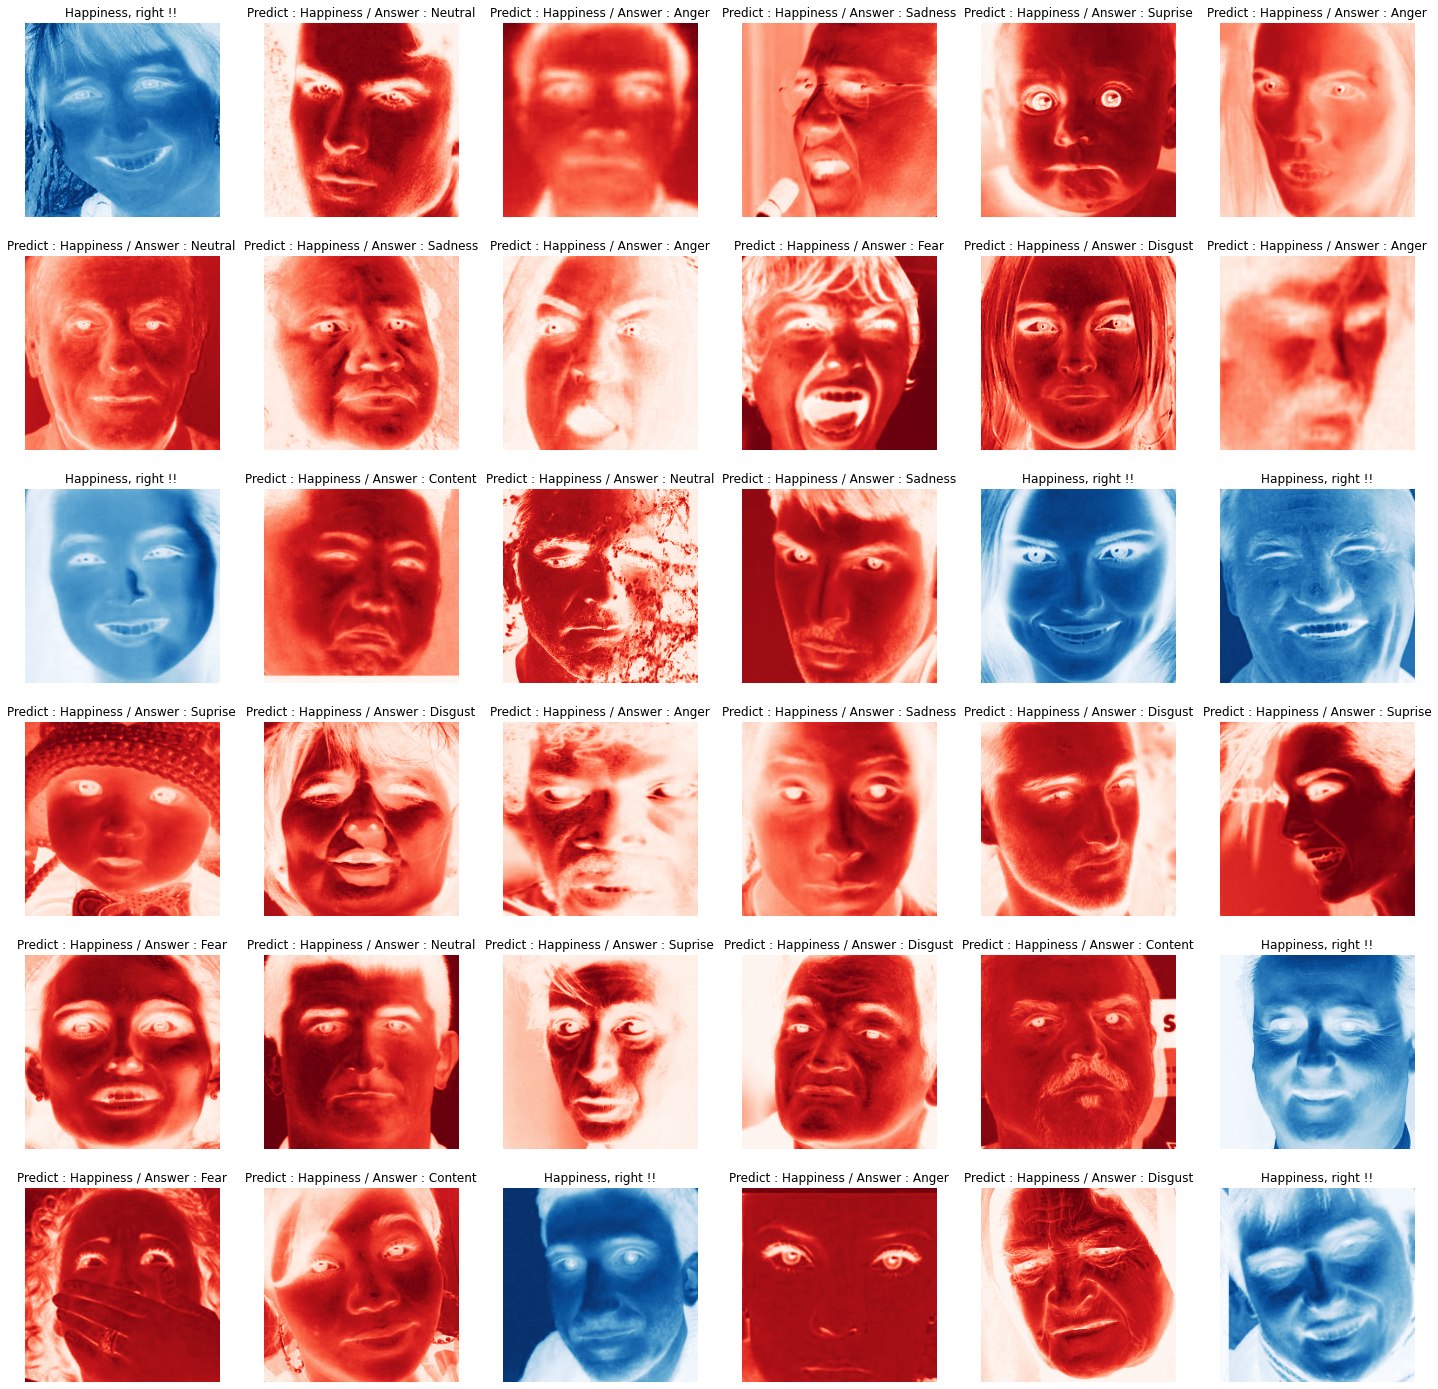

In [89]:
columns = 6
rows = 6
fig = plt.figure(figsize=(25,25))

# inference
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device) 

    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = label_tags[argmax.item()]
    #test_dataset = test_dataset.numpy()
    label = label_tags[test_dataset[data_idx][1].item()]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right !!')
        cmap = 'Blues'
    else:
        plt.title('Predict : ' + pred + ' / Answer : ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')
    
plt.show() 

In [191]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# 테스트 데이터에 대한 모델 테스트
https://learn.microsoft.com/ko-kr/windows/ai/windows-ml/tutorials/pytorch-train-model #보류